<a href="https://colab.research.google.com/github/shalinramduth/ST444-Project/blob/main/Parallel_Bootstrap_and_Model_Evaluation_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
import concurrent.futures as cf
import seaborn as sns
import matplotlib.pyplot as plt

In [102]:
file = "https://raw.githubusercontent.com/shalinramduth/ST444-Project/main/ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(file)

# Round age, and Weight to integer; Round Height to 2 decimal places; As for other float64-type varialbes, they should be integer
integer = ["Age", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
df[integer] = df[integer].apply(np.int64)
df = df.round({"Height": 2})

# convert categorical variables
for column in df.columns:
  if df[column].dtypes == "object":
    df[column] = pd.factorize(df[column])[0]
        
# define x and y
x = df[df.columns[0:16]]; y = df[df.columns[16]]

times = list(np.linspace(100, 5000, num=10)) # create equal spaced sample size
times = [int(x) for x in times]

workers = [2,4,8] # number of processes that will be attempted to run at the same time
# the code was run on a laptop with 4 cores

df_time = pd.DataFrame(columns = ['no of samples'])
df_time['no of samples'] = times

In [103]:
# function that makes bootstrap samples

def h(n):
  X = df.sample(n=n,replace=True) # sample from training dataset
  return(np.mean(X))

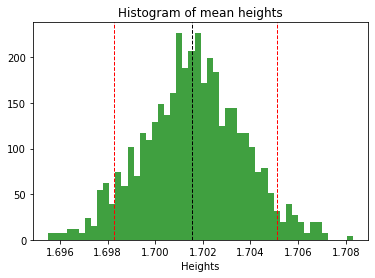

In [104]:
#Histogram of mean heights

hist = []
for x in range(1000):
  hist.append(h(2000))

hist2 = [his[2] for his in hist]

plt.hist(mee, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(np.mean(hist2), color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(hist2, 5), linestyle='dashed', linewidth=1, color = 'r')
plt.axvline(np.percentile(hist2, 95), linestyle='dashed', linewidth=1, color = 'r')
plt.title('Histogram of mean heights')
plt.xlabel('Heights')
plt.show()

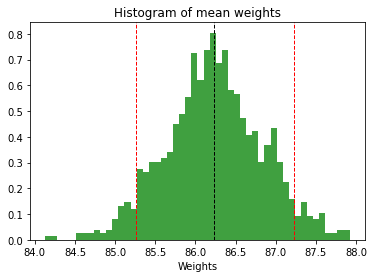

In [105]:
#Histogram of mean weights

hist3 = [his[3] for his in hist]
plt.hist(hist3, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(np.mean(hist3), color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(hist3, 5), linestyle='dashed', linewidth=1, color = 'r')
plt.axvline(np.percentile(hist3, 95), linestyle='dashed', linewidth=1, color = 'r')
plt.title('Histogram of mean weights')
plt.xlabel('Weights')
plt.show()

In [106]:
# serial function for bootstrap

meanli = []
stdli = []

# n = sample size; m = no of samples
def serial(n,m):
  #timing
  st = time.perf_counter()
  means = []
  for a in range(m):
    means.append(h(n))
  #mean and standard deviation of bootstrapped means are the calculated statistics
  meanli.append(np.mean(means,axis = 0))
  stdli.append(np.std(means, axis = 0))
  en = time.perf_counter()
  #returns the time taken
  return(en-st)

perf = []
for b in times:
  perf.append(serial(2000,b))
df_time['time taken serial'] = perf
df_time

,no of samples,time taken serial
0,100,0.265973
1,644,1.782095
2,1188,3.143293
3,1733,4.439875
4,2277,5.903454
5,2822,7.010100
6,3366,8.411645
7,3911,13.298045
8,4455,11.618193
9,5000,12.778220


In [107]:
# parallel function

meanli2 = []
stdli2 = []

def parallel(n,m,w):

  #n is how large each sample is, m is how many samples are taken
  inputs = [n]*m
  #timing the function
  start = time.perf_counter()

  if __name__ == "__main__":
    #uses current.futures module
    with cf.ProcessPoolExecutor(max_workers = w) as ex:

      #uses map to map h to the inputs
      results = ex.map(h, inputs)

      #the results are a generator object, which we convert to a list
      means = [x for x in results]

      #append to lists
      meanli2.append(np.mean(means))
      stdli2.append(np.std(means))

  finish = time.perf_counter()

            #time taken
  t = finish - start
  return(t)


for a in workers:
  p = []
  for b in times:
    p.append(parallel(2000,b,a))
  df_time['time taken parallel ({} workers)'.format(a)] = p
df_time
  


,no of samples,time taken serial,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers)
0,100,0.265973,0.332488,0.402280,0.460799
1,644,1.782095,2.052557,2.028113,2.284284
2,1188,3.143293,3.458355,3.702223,3.926549
3,1733,4.439875,5.153922,5.731943,5.464775
4,2277,5.903454,6.832230,7.224956,7.900947
5,2822,7.010100,8.371277,8.568016,12.965651
6,3366,8.411645,10.458752,10.466393,11.206407
7,3911,13.298045,11.380298,11.772711,13.114071
8,4455,11.618193,13.202437,13.541687,14.638278
9,5000,12.778220,14.462520,15.037206,15.949463


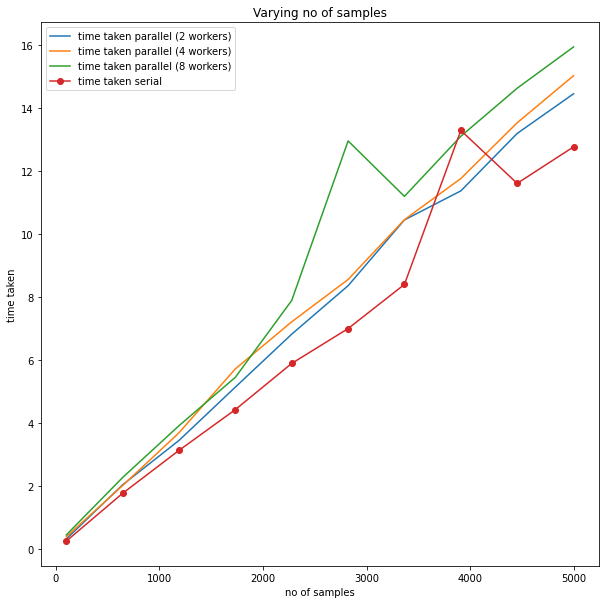

In [108]:
# visualization of time taken for the whole process
plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('no of samples', 'time taken parallel ({} workers)'.format(x), data=df_time, marker = '')

plt.plot('no of samples', 'time taken serial', data=df_time, marker = 'o')
#plt.plot()

plt.legend()
plt.xlabel('no of samples'); plt.ylabel('time taken (seconds)')
plt.title('Varying no of samples')

plt.show()

In [109]:
# serial function for bootstrap

df_time2 = pd.DataFrame(columns = ['sample size'])
df_time2['sample size'] = times

meanli = []
stdli = []

# changing sample size
perf = []
for b in times:
  perf.append(serial(b,1000))
df_time2['time taken serial'] = perf
df_time2

,sample size,time taken serial
0,100,2.408559
1,644,2.677592
2,1188,2.544601
3,1733,2.721995
4,2277,2.690262
5,2822,2.809329
6,3366,2.910575
7,3911,2.992249
8,4455,3.002834
9,5000,2.841233


In [110]:
# parallel changing sample size

meanli2 = []
stdli2 = []

for a in workers:
  p = []
  for b in times:
    p.append(parallel(b,1000,a))
  df_time2['time taken parallel ({} workers)'.format(a)] = p
df_time2

,sample size,time taken serial,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers)
0,100,2.408559,2.873848,3.389618,3.268086
1,644,2.677592,2.822858,3.406449,3.119801
2,1188,2.544601,3.048667,3.230412,3.395421
3,1733,2.721995,3.054626,3.231401,3.543685
4,2277,2.690262,3.069022,3.119214,3.295475
5,2822,2.809329,3.222184,3.331233,3.811779
6,3366,2.910575,3.252889,3.531149,3.635627
7,3911,2.992249,3.454673,3.842503,3.519546
8,4455,3.002834,3.506008,3.384214,3.754080
9,5000,2.841233,3.630280,3.593179,3.724885


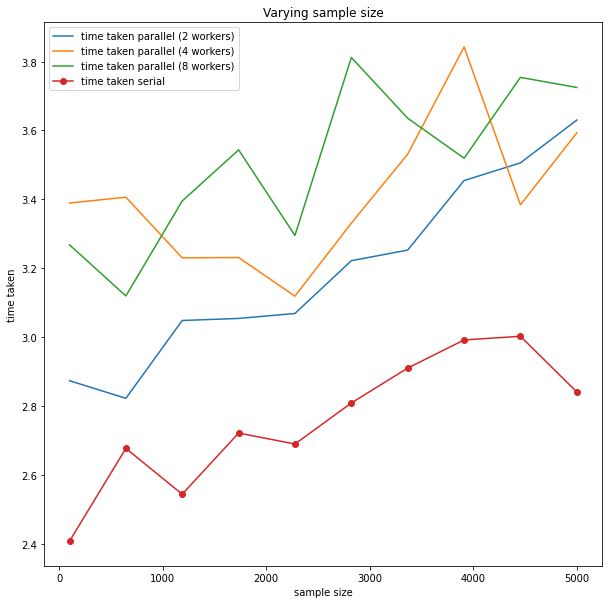

In [111]:
# visualization of time taken for the whole process
plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('sample size', 'time taken parallel ({} workers)'.format(x), data=df_time2, marker = '')

plt.plot('sample size', 'time taken serial', data=df_time2, marker = 'o')
#plt.plot()

plt.legend()
plt.xlabel('sample size'); plt.ylabel('time taken (seconds)')
plt.title('Varying sample size')
plt.show()

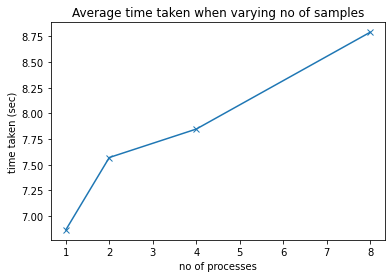

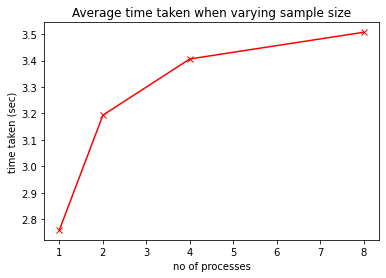

In [112]:
# Average time for each number of processes (serial function represented as 1 process)

ax1 = plt.plot([1,2,4,8],np.mean(df_time)[1:], marker = 'x')
plt.title('Average time taken when varying no of samples')
plt.xlabel('no of processes')
plt.ylabel('time taken (sec)')
plt.show()

ax2 = plt.plot([1,2,4,8],np.mean(df_time2)[1:], marker = 'x', color = 'r')
plt.title('Average time taken when varying sample size')
plt.xlabel('no of processes')
plt.ylabel('time taken (sec)')
plt.show()

In [113]:
#sampling and fitting the decision tree (but test set is the set not covered by the sampling) and return accuracy score

xx = df[df.columns[0:16]]; xy = df[df.columns[16]]

def g(n):
  big = list(xx.index)
  X = xx.sample(n=n,replace=True) # sample from training dataset
  #indexes of samples
  ind = set(X.index)
  Y = xy.loc[list(X.index)]
  #indexes of datapoints not in the sample
  rest = [x for x in big if x not in ind]
  xt = xx.loc[rest]
  yt = xy.loc[rest]
  clf = tree.DecisionTreeClassifier().fit(X,Y).predict(xt)
  return(accuracy_score(clf,yt))

df_time3 = pd.DataFrame(columns = ['no of samples'])
df_time3['no of samples'] = times

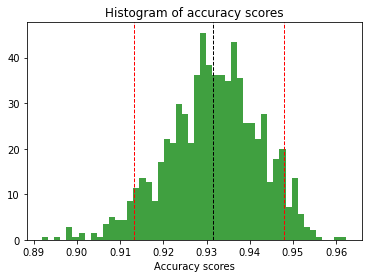

In [114]:
#histogram of accuracy scores for 1000 trials

hist = []

for x in range(1000):
  hist.append(g(2000))

plt.hist(hist, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(np.mean(hist), color='k', linestyle='dashed', linewidth=1)
#line for 5th percentile in accuracy scores calculated
plt.axvline(np.percentile(hist, 5), linestyle='dashed', linewidth=1, color = 'r')
#line for 95th percentile in accuracy scores calculated
plt.axvline(np.percentile(hist, 95), linestyle='dashed', linewidth=1, color = 'r')
plt.title('Histogram of accuracy scores')
plt.xlabel('Accuracy scores')
plt.show()

In [115]:
# serial function model evaluation

meanli = []
stdli = []

# n = sample size; m = no of samples
def serial2(n,m):
  st = time.perf_counter()

  meanacc = []
  for a in range(m):
    meanacc.append(g(n))
  #mean and standard deviation of bootstrapped means are the calculated statistics
  meanli.append(np.mean(meanacc,axis = 0))
  stdli.append(np.std(meanacc, axis = 0))
  en = time.perf_counter()
  return(en-st)

# changing no of samples

perf = []
for b in times:
  perf.append(serial2(2000,b))
df_time3['time taken serial'] = perf
df_time3

,no of samples,time taken serial
0,100,1.004448
1,644,6.824946
2,1188,12.536137
3,1733,17.472421
4,2277,22.951886
5,2822,29.436724
6,3366,35.365352
7,3911,39.443617
8,4455,44.963009
9,5000,51.399814


In [117]:
# parallel function model evaluation

meanli2 = []
stdli2 = []

def parallel2(n,m,w):

  #n is how large each sample is, m is how many samples are taken
  inputs = [n]*m
  #timing the function
  start = time.perf_counter()

  if __name__ == "__main__":
    #uses current.futures module
    with cf.ProcessPoolExecutor(max_workers = w) as ex:
      #uses map to match the function to the inputs
      results = ex.map(g, inputs)
      #ex.map returns a generator object which we need to convert to a list
      acc = [x for x in results]
      #mean and standard deviation of bootstrapped means are the calculated statistics
      meanli2.append(np.mean(acc,axis = 0))
      stdli2.append(np.std(acc, axis = 0))
    
  finish = time.perf_counter()
    #time taken
  t = finish - start
  return(t)

# changing no of samples

for a in workers:
  p = []
  for b in times:
    p.append(parallel2(2000,b,a))
  df_time3['time taken parallel ({} workers)'.format(a)] = p
df_time3

,no of samples,time taken serial,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers)
0,100,1.004448,1.002895,1.029137,1.077714
1,644,6.824946,5.448787,5.318320,5.832575
2,1188,12.536137,9.891802,9.906547,10.791107
3,1733,17.472421,13.857811,14.508472,15.293590
4,2277,22.951886,18.529253,18.647582,19.923022
5,2822,29.436724,22.912278,23.632278,23.759064
6,3366,35.365352,27.060305,27.131551,29.277891
7,3911,39.443617,34.054768,32.336186,34.544728
8,4455,44.963009,36.620889,36.225527,38.123599
9,5000,51.399814,40.207468,41.473429,43.188691


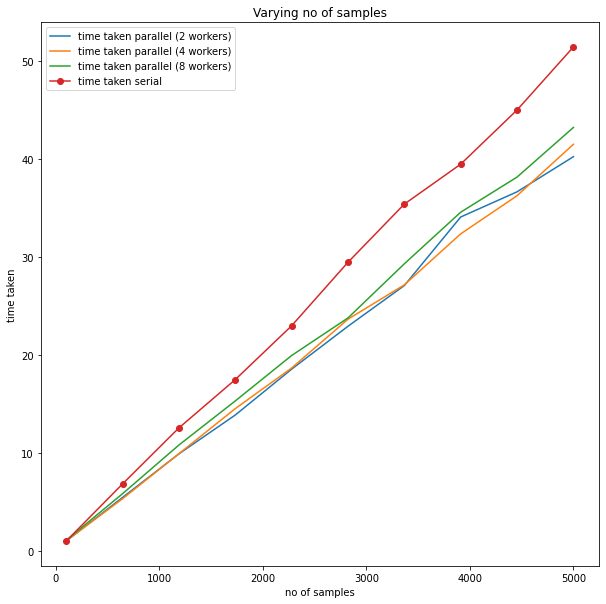

In [118]:
# visualization of time taken for the whole process
plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('no of samples', 'time taken parallel ({} workers)'.format(x), data=df_time3, marker = '')

plt.plot('no of samples', 'time taken serial', data=df_time3, marker = 'o')
plt.legend()
plt.xlabel('no of samples'); plt.ylabel('time taken (seconds)')
plt.title('Varying no of samples')
plt.show()

In [119]:
# vary sample size serial

df_time4 = pd.DataFrame(columns = ['sample size'])
df_time4['sample size'] = times

meanli = []
stdli = []

perf = []
for b in times:
  perf.append(serial2(b,1000))

df_time4['time taken serial'] = perf
df_time4

,sample size,time taken serial
0,100,5.537686
1,644,6.811980
2,1188,8.015136
3,1733,9.541783
4,2277,10.998099
5,2822,11.723461
6,3366,13.250268
7,3911,14.856141
8,4455,16.039467
9,5000,17.278489


In [120]:
# vary no of samples parallel

meanli2 = []
stdli2 = []

for a in workers:
  p = []
  for b in times:
    p.append(parallel2(b,1000,a))
  df_time4['time taken parallel ({} workers)'.format(a)] = p
df_time4

,sample size,time taken serial,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers)
0,100,5.537686,5.081436,5.309561,5.356978
1,644,6.811980,6.437055,6.514701,6.693971
2,1188,8.015136,7.679151,7.313827,7.142562
3,1733,9.541783,8.307424,8.063319,8.316484
4,2277,10.998099,9.826416,9.287171,9.016480
5,2822,11.723461,10.102092,9.897145,10.203610
6,3366,13.250268,13.652502,10.992938,11.451929
7,3911,14.856141,11.905069,12.050037,12.131026
8,4455,16.039467,12.534900,13.351028,12.921994
9,5000,17.278489,13.801972,13.816007,13.876454


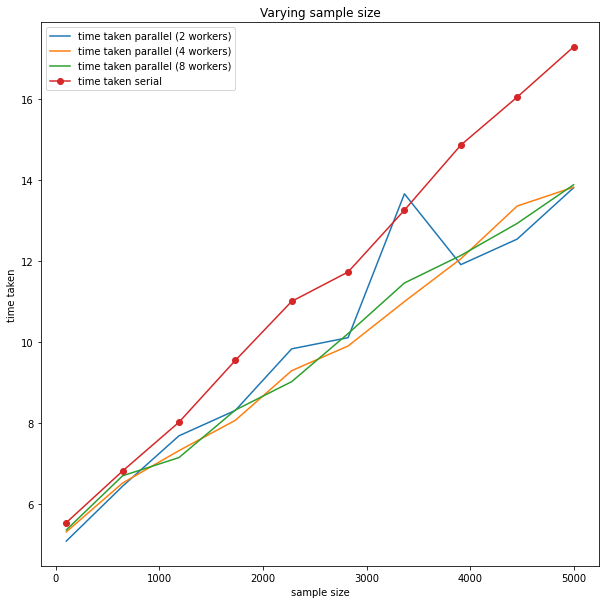

In [121]:
# visualization of time taken for the whole process
plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('sample size', 'time taken parallel ({} workers)'.format(x), data=df_time4, marker = '')

plt.plot('sample size', 'time taken serial', data=df_time4, marker = 'o')
plt.legend()
plt.xlabel('sample size'); plt.ylabel('time taken (seconds)')
plt.title('Varying sample size')
plt.show()

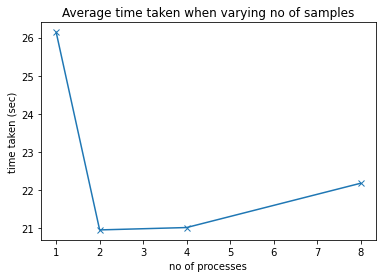

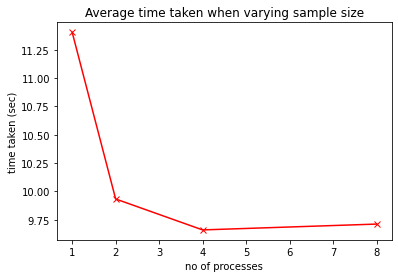

In [122]:
# Average time for each number of processes (serial function represented as 1 process)

ax1 = plt.plot([1,2,4,8],np.mean(df_time3)[1:], marker = 'x')
plt.title('Average time taken when varying no of samples')
plt.xlabel('no of processes')
plt.ylabel('time taken (sec)')
plt.show()

ax2 = plt.plot([1,2,4,8],np.mean(df_time4)[1:], marker = 'x', color = 'r')
plt.title('Average time taken when varying sample size')
plt.xlabel('no of processes')
plt.ylabel('time taken (sec)')
plt.show()